In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Some Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [7]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [8]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [9]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [10]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [11]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Parameter Search

In [107]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
    matrix_size_vals=np.array([6400]),
    r_vals=np.array([100, 200, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 6400]),
    lamb_vals=np.array([0, 1e-12, 1e-8, 1e-3, 1e-2, 1e-1, 0.5]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)

In [111]:
wake_ret = parameter_search(wake_signal_unnormed[:15000], wake_signal_unnormed[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

  0%|          | 0/1428 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
pd.to_pickle(wake_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_unnormed_{area}_10000_3000.pkl'))
# wake_ret = pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_{area}.pkl'))

In [ ]:
anesthesia_ret = parameter_search(anesthesia_signal_unnormed[:15000], anesthesia_signal_unnormed[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

In [109]:
pd.to_pickle(anesthesia_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'anesthesia_ret_mary_unnormed_{area}_10000_3000.pkl'))

# Performance

In [85]:
# explained_variance_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.explained_variance.unique()])
r_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.r.unique()])
lamb_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.lamb.unique()])

wake_ip = np.zeros((len(lamb_vals), len(r_vals)))
anesthesia_ip = np.zeros((len(lamb_vals), len(r_vals)))

for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_ip[j, i] = wake_ret[np.logical_and(wake_ret.r == r, wake_ret.lamb == lamb)].ip
        if np.isnan(wake_ip[j, i]):
            wake_ip[j, i] = -1
        elif wake_ip[j, i] < -1:
            wake_ip[j, i] = -1
        
        anesthesia_ip[j, i] = anesthesia_ret[np.logical_and(anesthesia_ret.r == r, anesthesia_ret.lamb == lamb)].ip
        if np.isnan(anesthesia_ip[j, i]):
            anesthesia_ip[j, i] = -1
        elif anesthesia_ip[j, i] < -1:
            anesthesia_ip[j, i] = -1

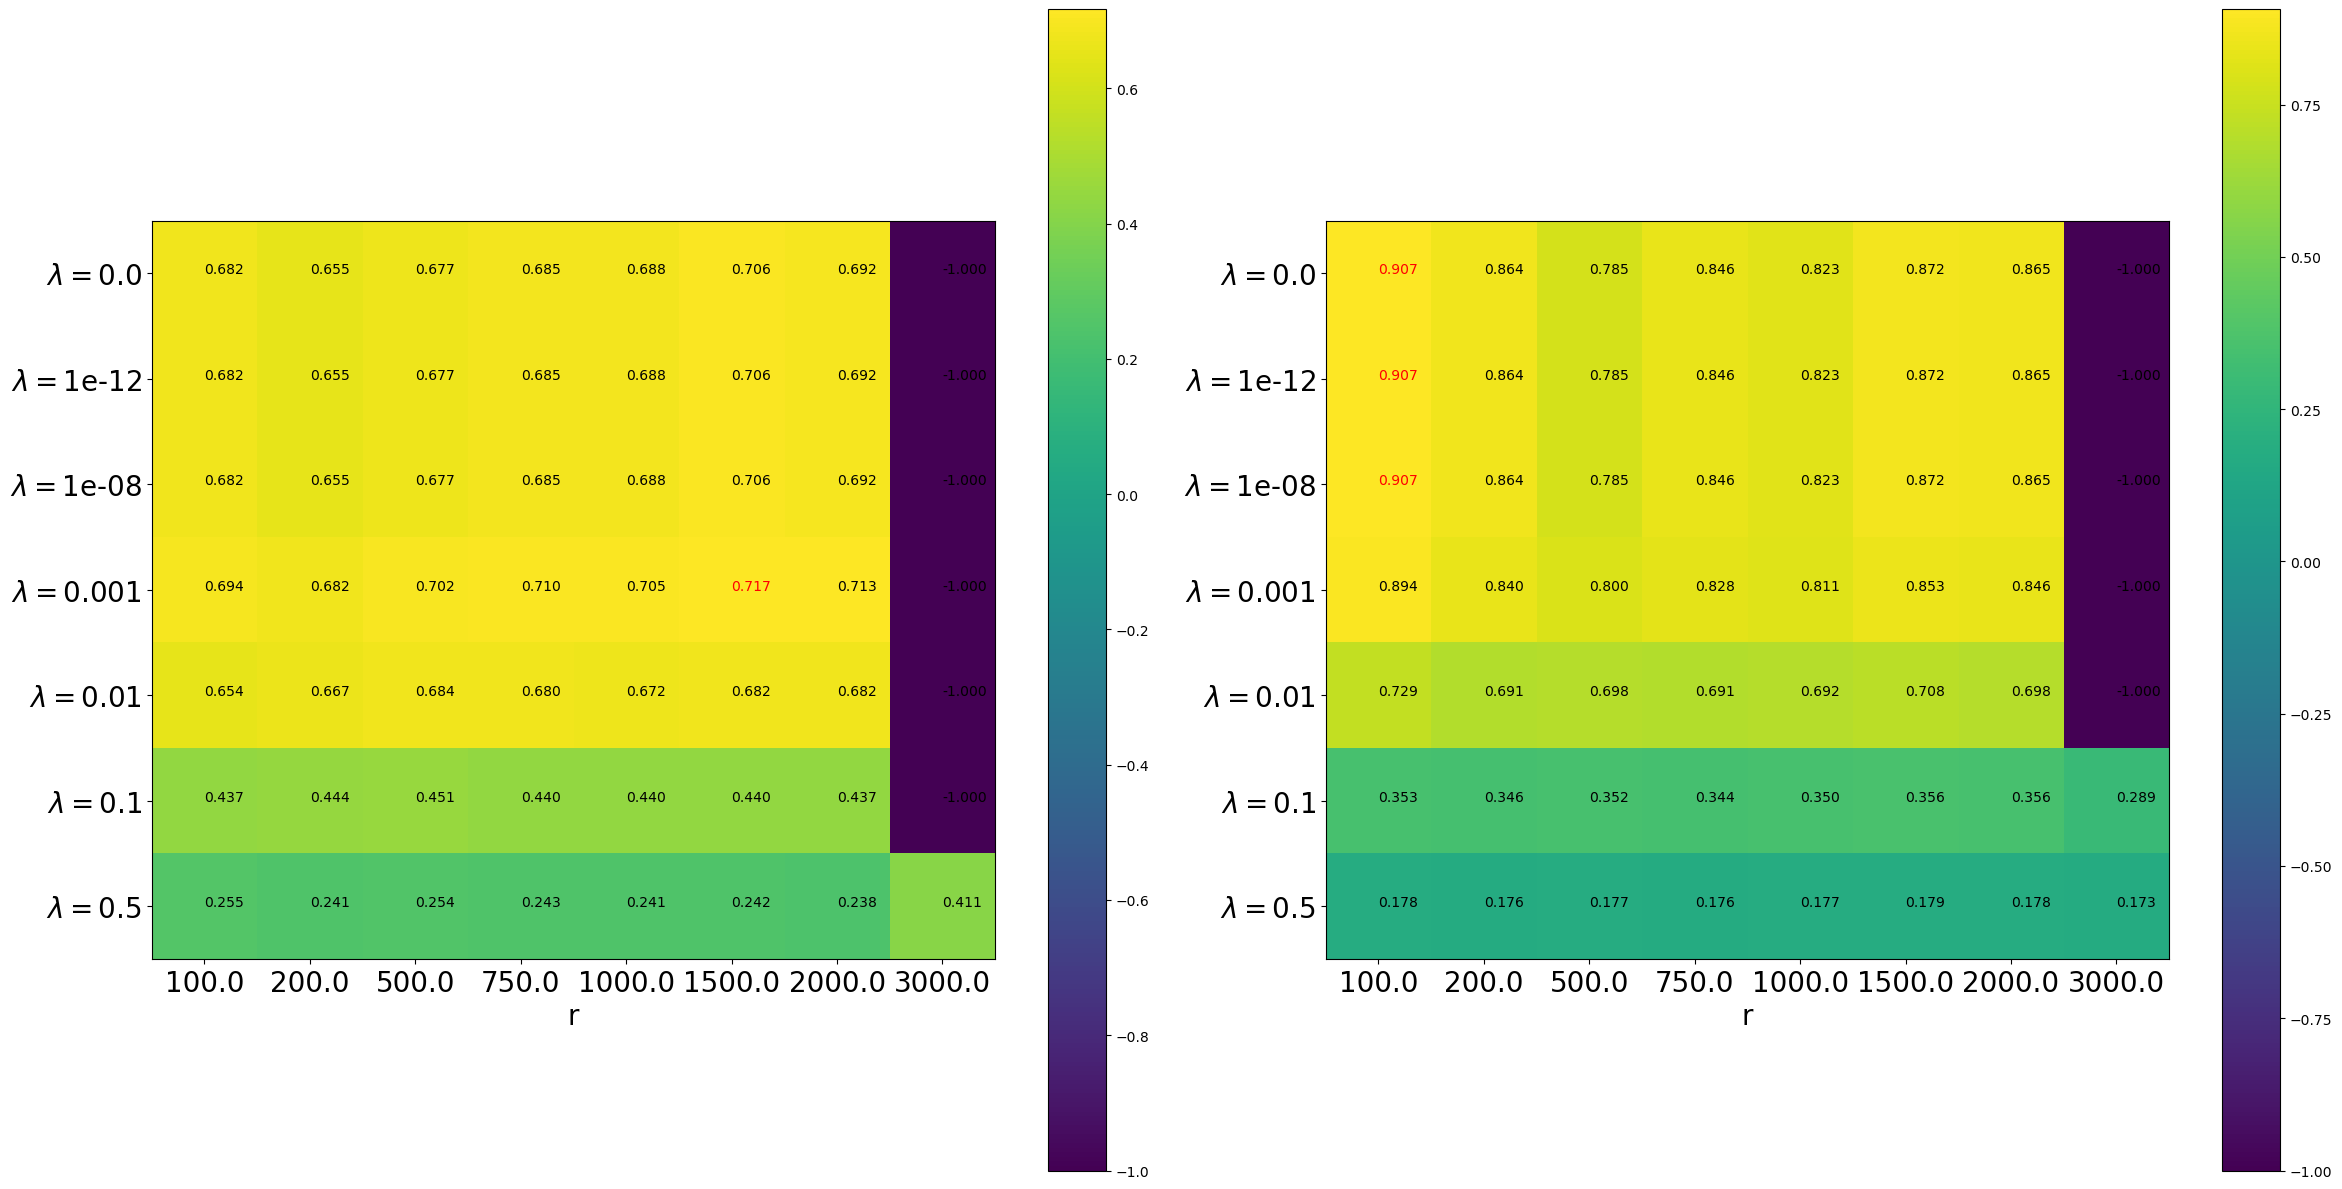

In [86]:
# min_r_thresh = 0.01
ip = wake_ip
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.imshow(ip)
plt.colorbar()
plt.xticks(np.arange(len(r_vals)), [f"{r}" for r in r_vals])
plt.xlabel("r", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{lamb}" for lamb in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)


ip = anesthesia_ip
plt.subplot(1, 2, 2)
plt.imshow(ip)
plt.colorbar()
plt.xticks(np.arange(len(r_vals)), [f"{r}" for r in r_vals])
plt.xlabel("r", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{lamb}" for lamb in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

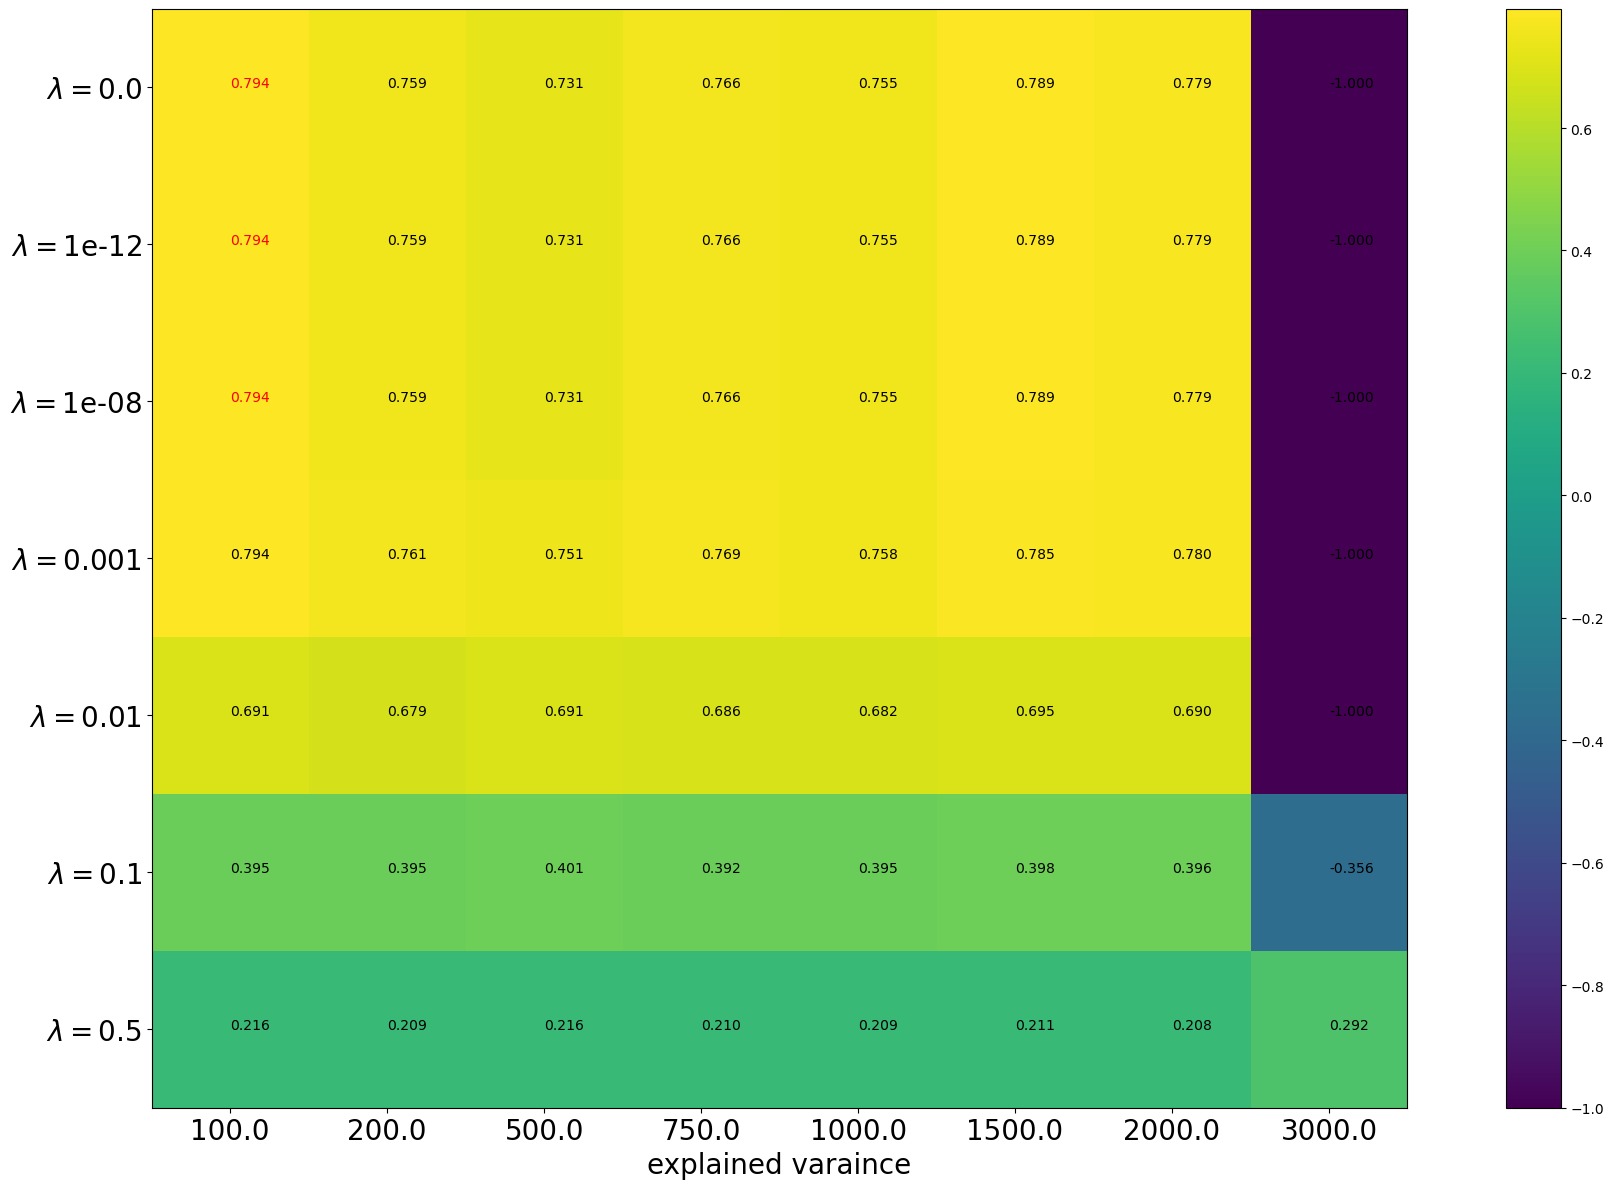

In [87]:
plt.figure(figsize=(20, 12))
ip_mat = (anesthesia_ip + wake_ip)/2
plt.imshow(ip_mat)
plt.colorbar()
plt.xticks(np.arange(len(r_vals)), [f"{r}" for r in r_vals])
plt.xlabel("explained varaince", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{lamb}" for lamb in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip_mat.max()
for i in range(ip_mat.shape[0]):
    for j in range(ip_mat.shape[1]):
        if ip_mat[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip_mat[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

# Stability

In [88]:
# top_percent = 20
# wake_stab = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(len(x)*top_percent)]).to_numpy()[0]
# anesthesia_stab = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(len(x)*top_percent)]).to_numpy()[0]

In [89]:
top_percent = 0.2

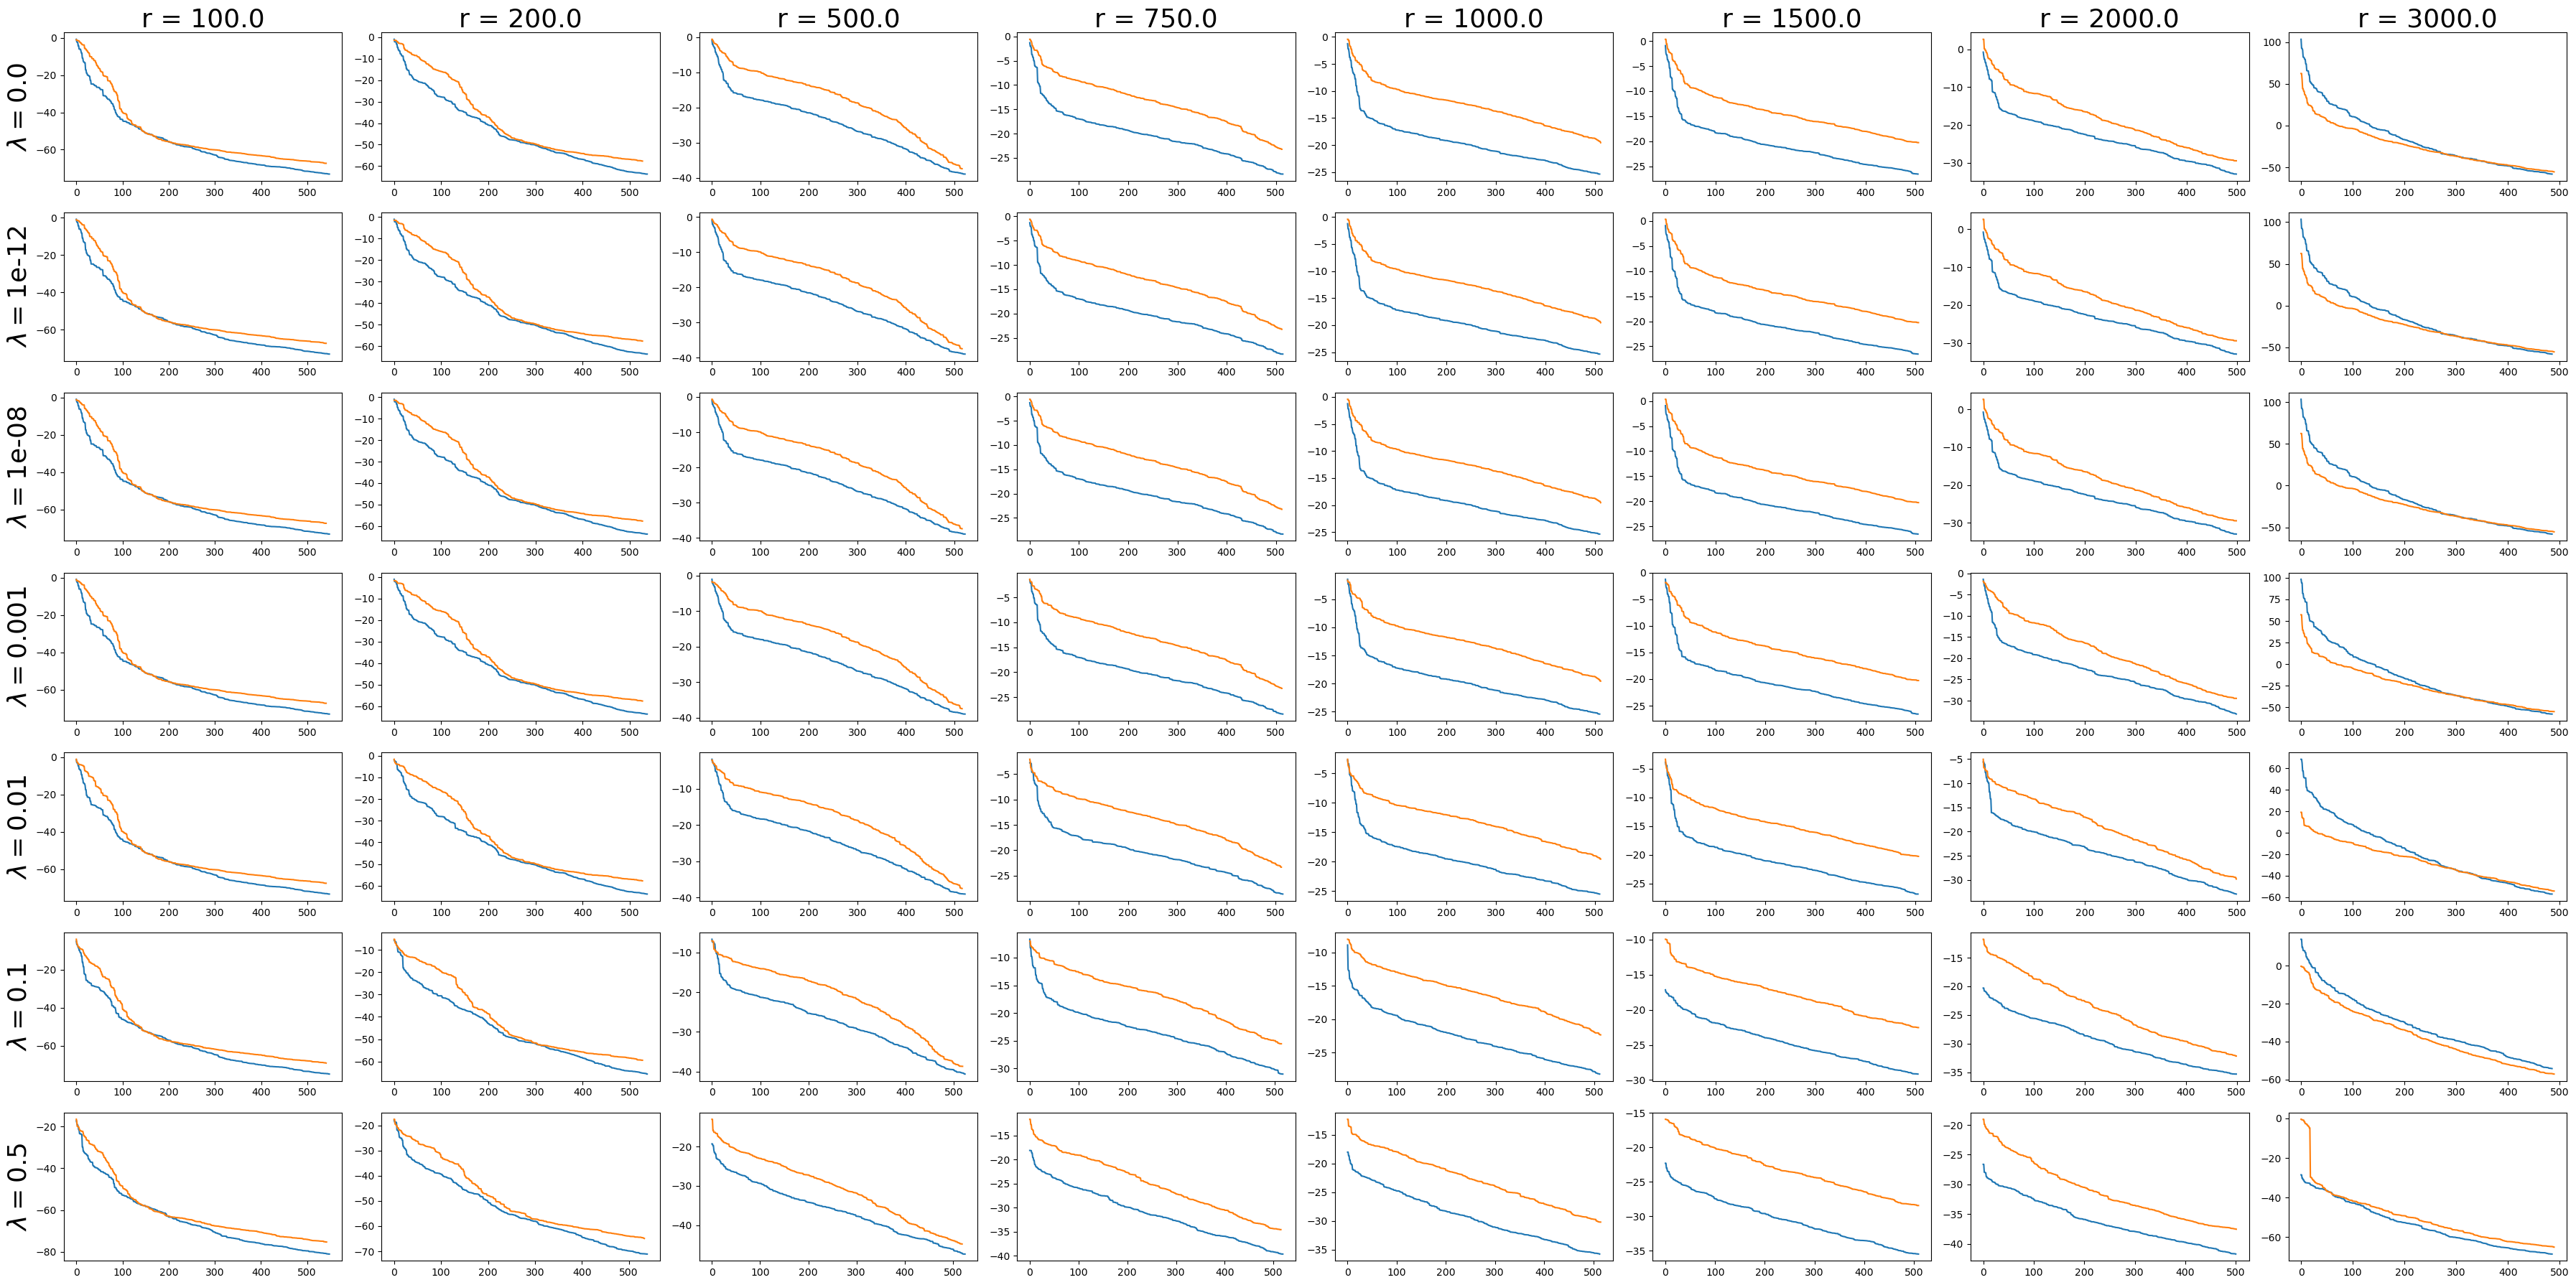

In [90]:
fig, axs = plt.subplots(len(lamb_vals), len(r_vals), figsize=(36, 18))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_curve = wake_ret[np.logical_and(wake_ret.r == r, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r == r, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        ax = axs[j, i]
        ax.plot(wake_curve)
        ax.plot(anesthesia_curve)
#         ax2.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("r = " + f"{r}", fontsize=26)
plt.tight_layout()
plt.show()

100.0 0.0
100.0 1e-12
100.0 1e-08
100.0 0.001
100.0 0.01
200.0 0.0
200.0 1e-12
200.0 1e-08
200.0 0.001
200.0 0.01
500.0 0.0
500.0 1e-12
500.0 1e-08
500.0 0.001
500.0 0.01
750.0 0.0
750.0 1e-12
750.0 1e-08
750.0 0.001
750.0 0.01
1000.0 0.0
1000.0 1e-12
1000.0 1e-08
1000.0 0.001
1000.0 0.01
1500.0 0.0
1500.0 1e-12
1500.0 1e-08
1500.0 0.001
1500.0 0.01
2000.0 0.0
2000.0 1e-12
2000.0 1e-08
2000.0 0.001
2000.0 0.01


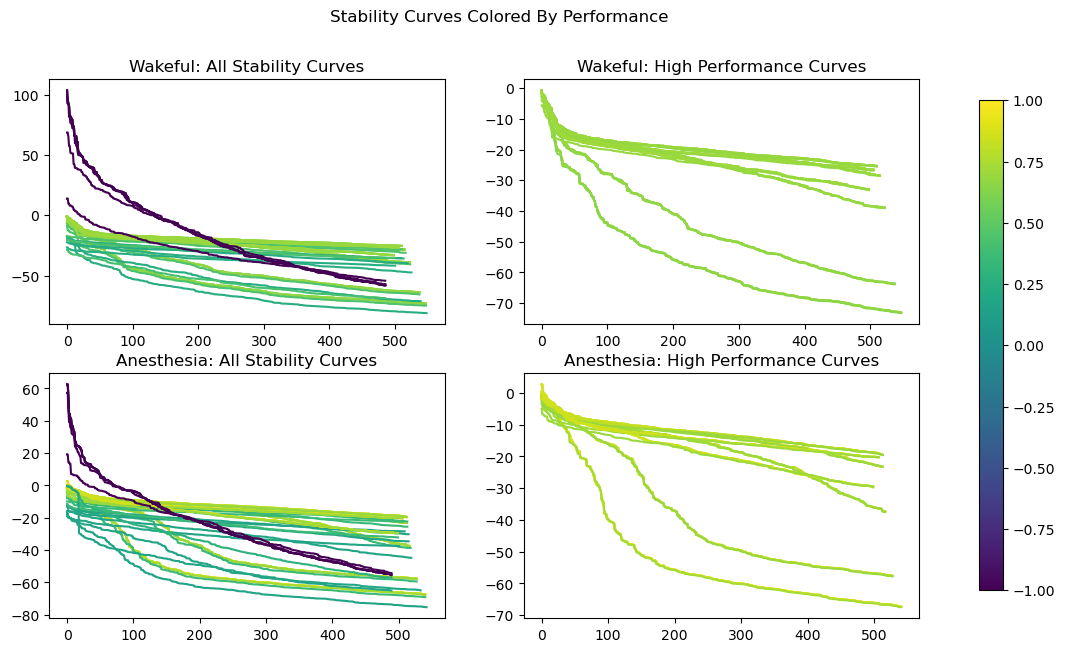

In [104]:
performance_thresh = 0.65
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_curve = wake_ret[np.logical_and(wake_ret.r == r, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r == r, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        axs[0, 0].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
        if wake_ip[j, i] > performance_thresh:
            axs[0, 1].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))

        axs[1, 0].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
        if anesthesia_ip[j, i] > performance_thresh:
            axs[1, 1].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
            
            if anesthesia_curve[-1] < -10:
                print(r, lamb)

axs[0, 0].set_title('Wakeful: All Stability Curves')
axs[0, 1].set_title('Wakeful: High Performance Curves')
axs[1, 0].set_title('Anesthesia: All Stability Curves')
axs[1, 1].set_title('Anesthesia: High Performance Curves')
fig.suptitle('Stability Curves Colored By Performance')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

0.6818085051774978
0.6547487338185309
0.6767749171257019
0.6854918343424796
0.6880386374592781
0.706034683227539
0.6923383416533471


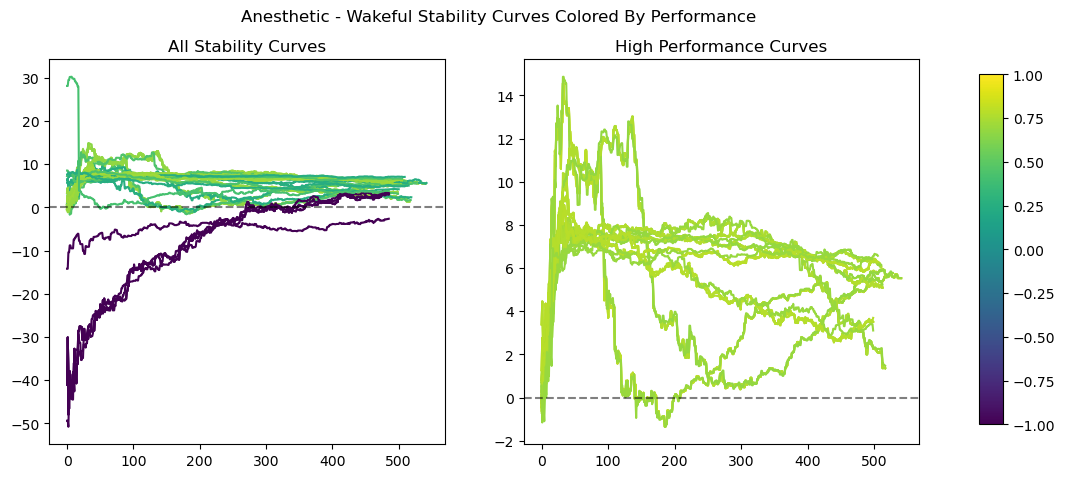

In [106]:
performance_thresh = 0.6
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        if r == 100:
            print(wake_ip[i, j])
        wake_curve = wake_ret[np.logical_and(wake_ret.r == r, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r == r, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        min_length = np.min([len(wake_curve), len(anesthesia_curve)])    
        axs[0].plot(anesthesia_curve[:min_length] - wake_curve[:min_length], c=cmap(norm(wake_ip[j, i])))
        if wake_ip[j, i] > performance_thresh and anesthesia_ip[j, i] > performance_thresh:
            axs[1].plot(anesthesia_curve[:min_length] - wake_curve[:min_length], c=cmap(norm((wake_ip[j, i] + anesthesia_ip[j, i])/2)))
axs[0].axhline(0, linestyle='--', c='k', alpha=0.5)
axs[1].axhline(0, linestyle='--', c='k', alpha=0.5)
axs[0].set_title('All Stability Curves')
axs[1].set_title('High Performance Curves')
fig.suptitle('Anesthetic - Wakeful Stability Curves Colored By Performance')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

# Picking One

In [177]:
delase_wake = DeLASE(wake_signal_unnormed[:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')
delase_anesthesia = DeLASE(anesthesia_signal_unnormed[:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')

In [178]:
wake_explained_variance = torch.cumsum(delase_wake.S.cpu()**2/((delase_wake.S.cpu()**2).sum()), 0)
anesthesia_explained_variance = torch.cumsum(delase_anesthesia.S.cpu()**2/((delase_anesthesia.S.cpu()**2).sum()), 0)

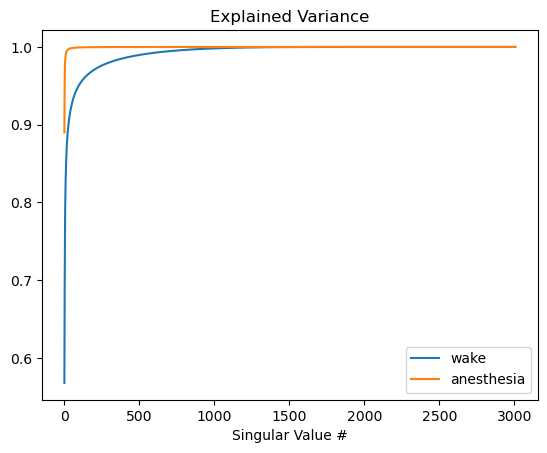

In [179]:
plt.plot(wake_explained_variance, label='wake')
plt.plot(anesthesia_explained_variance, label='anesthesia')
plt.title('Explained Variance')
plt.xlabel('Singular Value #')
plt.legend()
plt.show()

In [219]:
thresh = 0.99

In [220]:
r = int(np.argmax(wake_explained_variance > thresh))
r

510

In [221]:
delase_wake.compute_havok_dmd(r=r, lamb=0)
delase_wake.compute_jacobians()
delase_wake.get_stability(max_freq=500, max_unstable_freq=125)
delase_anesthesia.compute_havok_dmd(r=r, lamb=0)
delase_anesthesia.compute_jacobians()
delase_anesthesia.get_stability(max_freq=500, max_unstable_freq=125)

In [222]:
top_percent = 0.1

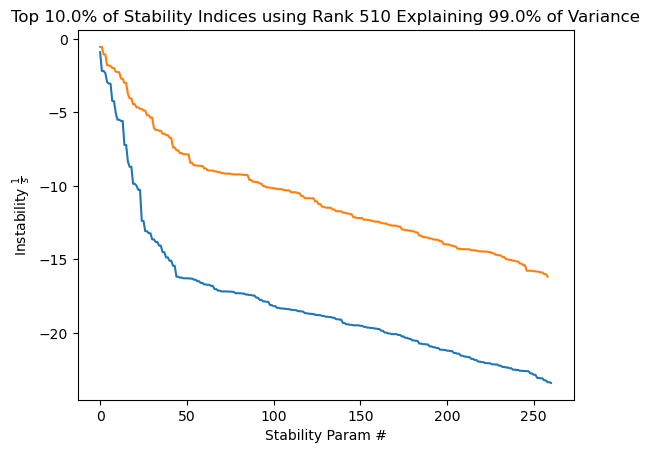

In [223]:
plt.plot(delase_wake.stability_params.cpu()[:int(len(delase_wake.stability_params.cpu())*top_percent)], label='wake')
plt.plot(delase_anesthesia.stability_params.cpu()[:int(len(delase_anesthesia.stability_params.cpu())*top_percent)], label='anesthesia')
plt.ylabel(r'Instability $\frac{1}{s}$')
plt.xlabel('Stability Param #')
plt.title(f'Top {top_percent*100}% of Stability Indices using Rank {r} Explaining {thresh*100}% of Variance')
plt.show()

In [224]:
def swap_phase(x, y):
    new_x = np.zeros(x.shape)
    new_y = np.zeros(y.shape)
#     n_fft = 2000
    n_fft = x.shape[0]
    for i in range(x.shape[1]):
        x_fft = np.fft.fft(x[:, i], n=n_fft)
        y_fft = np.fft.fft(y[:, i], n=n_fft)

        x_mag, x_angle = np.abs(x_fft), np.angle(x_fft)
        y_mag, y_angle = np.abs(y_fft), np.angle(y_fft)
        
        new_x[:, i] = np.real(np.fft.ifft(x_mag*np.exp(1j*y_angle), n=n_fft))
        new_y[:, i] = np.real(np.fft.ifft(y_mag*np.exp(1j*x_angle), n=n_fft))
    return new_x, new_y

In [225]:
wake_swapped, anesthesia_swapped = swap_phase(wake_signal_unnormed, anesthesia_signal_unnormed)

In [226]:
delase_wake2 = DeLASE(wake_swapped[:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')
delase_anesthesia2 = DeLASE(anesthesia_swapped[:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')

In [227]:
delase_wake2.compute_havok_dmd(r=r, lamb=0)
delase_wake2.compute_jacobians()
delase_wake2.get_stability(max_freq=500, max_unstable_freq=125)
delase_anesthesia2.compute_havok_dmd(r=r, lamb=0)
delase_anesthesia2.compute_jacobians()
delase_anesthesia2.get_stability(max_freq=500, max_unstable_freq=125)

In [228]:
top_percent = 0.1

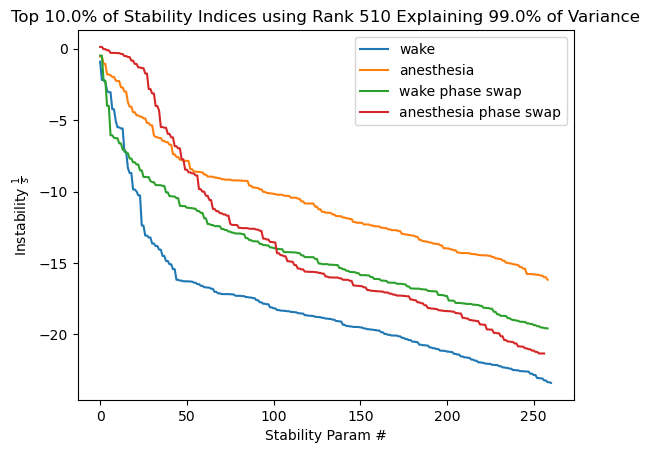

In [229]:
plt.plot(delase_wake.stability_params.cpu()[:int(len(delase_wake.stability_params.cpu())*top_percent)], label='wake')
plt.plot(delase_anesthesia.stability_params.cpu()[:int(len(delase_anesthesia.stability_params.cpu())*top_percent)], label='anesthesia')
plt.plot(delase_wake2.stability_params.cpu()[:int(len(delase_wake2.stability_params.cpu())*top_percent)], label='wake phase swap')
plt.plot(delase_anesthesia2.stability_params.cpu()[:int(len(delase_anesthesia2.stability_params.cpu())*top_percent)], label='anesthesia phase swap')
plt.ylabel(r'Instability $\frac{1}{s}$')
plt.xlabel('Stability Param #')
plt.title(f'Top {top_percent*100}% of Stability Indices using Rank {r} Explaining {thresh*100}% of Variance')
plt.legend()
plt.show()